In [1]:
#!/usr/bin/python
#dbr 10/20/23
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.cm as cm
import seaborn as sns

sns.set_style("ticks")


In [2]:

#additional 4 cytokines
cdf4 = pd.read_csv('data/sep2023-update/PAD_OPH_combined_4plex_appended_meta.csv')

#cdf4 = cdf4.rename(columns={'seattle_masterptid':'id'}) #switch for easy monolix output merge

cdf4 = cdf4[cdf4['Experiment']=='OPH_Uplex'].dropna() #just OPH

#add short ids
sid=[]
for i in range(len(cdf4['seattle_masterptid'])):
    pid=cdf4['seattle_masterptid'].iloc[i]
    sid.append(float(str(pid)[4:7]))

cdf4['id']=sid

cdf4 = cdf4[['id','MSD_month_code','level_GranzymeB','level_IL15', 'level_IL7','level_IL2']]

#rename columns
cyts0 = ['level_GranzymeB', 'level_IL15', 'level_IL7','level_IL2']

for c in cyts0:
    cdf4 = cdf4.rename(columns={c:c.split('_')[1]}) 

cdf4 = cdf4.rename(columns={'GranzymeB':'GzB'})
    
cdf4.head()

,id,MSD_month_code,GzB,IL15,IL7,IL2
0,100.0,0.0,52.216867,8.682214,12.449713,21.537602
1,101.0,42.0,6.303174,10.475696,11.665124,46.983967
2,102.0,0.0,20.485860,3.689544,9.820990,17.045871
3,102.0,24.0,8.741411,4.500387,5.669352,17.442343
4,102.0,41.0,40.561603,11.164378,18.447800,47.156955


In [3]:
#switch to log-scale for gzb? or all??

cs=['GzB','IL15', 'IL7','IL2']
for c in cs:
    cdf4[c]=np.log10(cdf4[c])

In [4]:
#get baseline
baseline_levels = cdf4[cdf4['MSD_month_code']==0]

In [16]:
#get median after 1 year
setpoint = cdf4[cdf4['MSD_month_code']>11].groupby('id').mean()

setpoint = setpoint.reset_index()

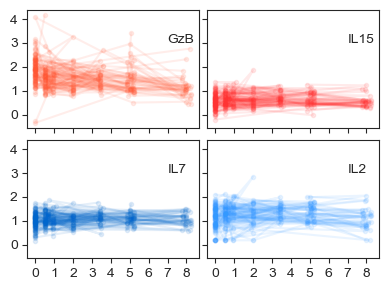

In [17]:
#plot cytokine levels

cs=['GzB','IL15', 'IL7','IL2']
cz = ['#FF5733','#FF3333','#0066CC','#3399FF']

xx = np.linspace(0,100,100)
fig,axs = plt.subplots(2,2,figsize=(4,3),sharex=True,sharey=True)
for i,c in enumerate(cs):
    ax=axs[int(i/2)][i%2]
    
    for p in cdf4['id'].unique():        
        tdf = cdf4[cdf4['id']==p]
        ax.plot(tdf['MSD_month_code']/12,tdf[c],color=cz[i],alpha=0.1,marker='.')
    
    #yy = 10**(xx*np.mean(crdf[c+'_rate'])+np.mean(crdf[c+'_int']))
    #ax.plot(xx,yy,color='k')
    ax.annotate(c,[7,3])#,color=cz[i])
    
#ax.set_ylim([1,1e3])
ax.set_xticks(range(0,9,))
ax.set_yticks(range(5))
        
#plt.xlabel('Time (months since ART)')
plt.tight_layout()
plt.subplots_adjust(hspace=0.1,wspace=0.05)
plt.savefig('figures/cytokines.pdf',dpi=600)


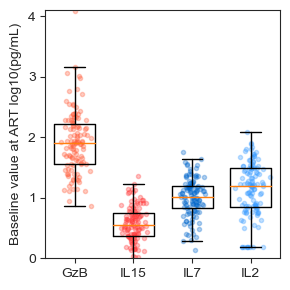

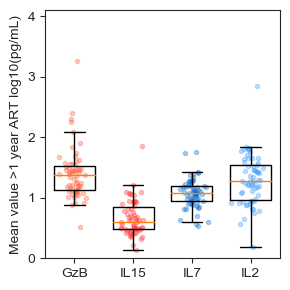

In [18]:
#boxplot measures
plt.figure(figsize=(3,3))
jit=0.1
plt.boxplot(baseline_levels[cs],widths=0.7,showfliers=False)
for i,c in enumerate(cs):
    plt.scatter(np.random.normal(i+1,jit,len(baseline_levels)),baseline_levels[c],color=cz[i],alpha=0.3,marker='.')
plt.xticks(range(1,5),cs)
plt.ylabel('Baseline value at ART log10(pg/mL)')
plt.yticks(range(5))
plt.ylim([0,4.1])

plt.tight_layout()
plt.savefig('figures/cytokines-baseline-values.pdf',dpi=600)

plt.figure(figsize=(3,3))
jit=0.1
plt.boxplot(setpoint[cs],widths=0.7,showfliers=False)
for i,c in enumerate(cs):
    plt.scatter(np.random.normal(i+1,jit,len(setpoint)),setpoint[c],color=cz[i],alpha=0.3,marker='.')
plt.xticks(range(1,5),cs)
plt.yticks(range(5))
plt.ylim([0,4.1])
plt.ylabel('Mean value >1 year ART log10(pg/mL)')
plt.tight_layout()
plt.savefig('figures/cytokines-setpoint-values.pdf',dpi=600)


/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_93519/2294843555.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_93519/2294843555.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


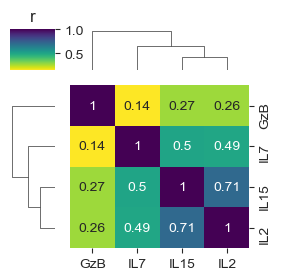

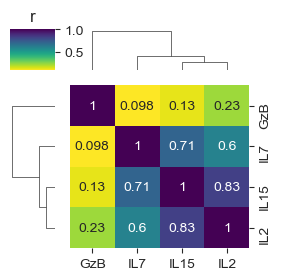

In [19]:
sns.clustermap(baseline_levels[cs].corr(method='pearson'),figsize=(3,3),cmap='viridis_r',annot=True)
plt.title('r')
plt.tight_layout()
plt.savefig('figures/cytokines-selfcorr-baseline.pdf',dpi=600)

sns.clustermap(setpoint[cs].corr(method='pearson'),figsize=(3,3),cmap='viridis_r',annot=True)
plt.title('r')
plt.tight_layout()
plt.savefig('figures/cytokines-selfcorr-setpoint.pdf',dpi=600)


In [20]:
#the IPDA cell virus decay rates for monolix
HIV_rate_df = pd.read_csv('rates_monolix_indiv.csv')

ds1 = ['RNA<1(1)','RNA<1(2)','Intact<1','Defective<1','CD4<1']
ds2 = ['Intact>1','Defective>1','CD4>1']

#switch all signs!
for c in ds1+ds2:
    HIV_rate_df[c]=np.abs(HIV_rate_df[c])

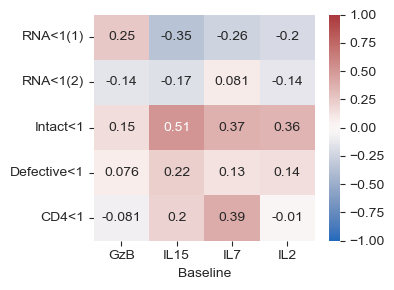

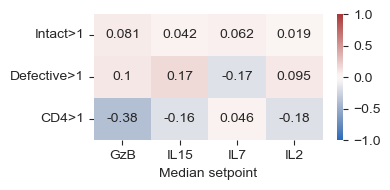

In [21]:
#now merge and look at correlations

### first baseline
adf = pd.merge(baseline_levels,HIV_rate_df,on='id',how='inner').dropna() #merged for rates
adf.drop(columns=['Unnamed: 0','id','MSD_month_code'],inplace=True)
corrdf = adf.corr(method='pearson')

plt.figure(figsize=(4,3))
sns.heatmap(corrdf.loc[ds1,cs],annot=True,cmap='vlag',vmin=-1,vmax=1)
plt.xlabel('Baseline')
plt.tight_layout()
plt.savefig('figures/cytokines-base-corr.pdf',dpi=600)

### second long term avg
adf2 = pd.merge(setpoint,HIV_rate_df,on='id',how='inner').dropna() #merged for rates
adf2.drop(columns=['Unnamed: 0','id','MSD_month_code'],inplace=True)
corrdf = adf2.corr(method='pearson')

plt.figure(figsize=(4,2))
sns.heatmap(corrdf.loc[ds2,cs],annot=True,cmap='vlag',vmin=-1,vmax=1)
plt.xlabel('Median setpoint')
plt.tight_layout()
plt.savefig('figures/cytokines-setpoint-corr.pdf',dpi=600)


MannwhitneyuResult(statistic=1350.0, pvalue=0.08179267035491625)
MannwhitneyuResult(statistic=439.0, pvalue=0.7588363865917294)
MannwhitneyuResult(statistic=1377.5, pvalue=0.11234912649282269)
MannwhitneyuResult(statistic=334.0, pvalue=0.21111666443061172)
MannwhitneyuResult(statistic=1419.0, pvalue=0.17467526915605724)
MannwhitneyuResult(statistic=300.0, pvalue=0.07846093360770297)
MannwhitneyuResult(statistic=1550.5, pvalue=0.5303566765927819)
MannwhitneyuResult(statistic=451.0, pvalue=0.6264554467128376)


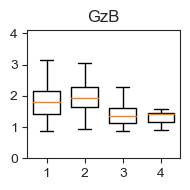

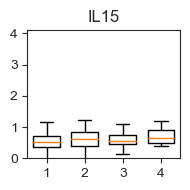

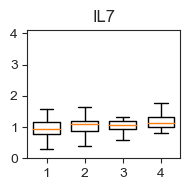

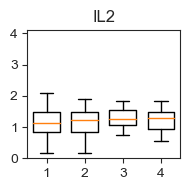

In [25]:
#compare excluded/included

inc_baseline = baseline_levels[baseline_levels['id'].isin(HIV_rate_df['id'])]
exc_baseline = baseline_levels[~baseline_levels['id'].isin(HIV_rate_df['id'])]

inc_sp = setpoint[setpoint['id'].isin(HIV_rate_df['id'])]
exc_sp = setpoint[~setpoint['id'].isin(HIV_rate_df['id'])]

#boxplots
for c in cs:
    plt.figure(figsize=(2,2))
    plt.boxplot([inc_baseline[c],exc_baseline[c],inc_sp[c],exc_sp[c]],widths=0.7,showfliers=False)

    print(st.mannwhitneyu(inc_baseline[c],exc_baseline[c]))
    print(st.mannwhitneyu(inc_sp[c],exc_sp[c]))
    
    plt.yticks(range(5))
    plt.ylim([0,4.1])
    plt.title(c)

    plt.tight_layout()
    plt.savefig('figures/cytokines-incvsexc'+c+'.pdf',dpi=600)


/Users/dreeves/anaconda3/lib/python3.11/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


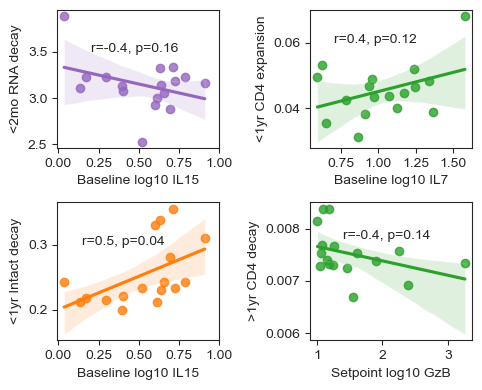

In [11]:
#show some interesting/significant ones
#use data type colors (vs cytokine colors?)

fig,axs = plt.subplots(2,2,figsize=(5,4),sharex=False,sharey=False)

ax=axs[0][0]
sns.regplot(adf['IL15'],adf['RNA<1(1)'],color='tab:purple',ax=ax)
#sns.regplot(adf['IL15'],adf['RNA<1(1)'],color='#FF3333',ax=axs[0])
r,p=st.pearsonr(adf['IL15'],adf['RNA<1(1)'])
ax.annotate('r='+str(np.round(r,1))+', p='+str(np.round(p,2)),[0.2,3.5])
ax.set_xlabel('Baseline log10 IL15')
ax.set_ylabel('<2mo RNA decay',fontsize=10)
ax.set_xticks(np.linspace(0,1,5))

#sns.regplot(adf['IL15'],adf['Intact<1'],color='#FF3333',ax=axs[1])
ax=axs[1][0]
sns.regplot(adf['IL15'],adf['Intact<1'],color='tab:orange',ax=ax)
ax.set_ylabel('<1yr Intact decay')
r,p=st.pearsonr(adf['IL15'],adf['Intact<1'])
ax.annotate('r='+str(np.round(r,1))+', p='+str(np.round(p,2)),[0.15,0.3])
ax.set_xlabel('Baseline log10 IL15')
ax.set_xticks(np.linspace(0,1,5))

ax=axs[0][1]
#sns.regplot(adf['IL7'],adf['CD4<1'],color='#0066CC',ax=axs[2])
sns.regplot(adf['IL7'],adf['CD4<1'],color='tab:green',ax=ax)
r,p=st.pearsonr(adf['IL7'],adf['CD4<1'])
ax.annotate('r='+str(np.round(r,1))+', p='+str(np.round(p,2)),[0.7,0.06])
ax.set_xlabel('Baseline log10 IL7')
ax.set_ylabel('<1yr CD4 expansion',fontsize=10)
ax.set_xticks([0.75,1,1.25,1.5])

ax=axs[1][1]
sns.regplot(adf2['GzB'],adf2['CD4>1'],color='tab:green',ax=ax)
#sns.regplot(adf2['GzB'],adf2['CD4>1'],color='#FF5733',ax=axs[3])
r,p=st.pearsonr(adf2['GzB'],adf2['CD4>1'])
ax.annotate('r='+str(np.round(r,1))+', p='+str(np.round(p,2)),[1.4,0.0078])
ax.set_xlabel('Setpoint log10 GzB')
ax.set_ylabel('>1yr CD4 decay',fontsize=10)

plt.tight_layout()
plt.savefig('figures/cytokines-corr-sig.pdf',dpi=600)


In [ ]:
#loop through and print pvalues??
measurenm=['baseline','setpoint']
for i,tdf in enumerate([adf,adf2]):
    print(measurenm[i])
    for c in cs:
        for d in ds:
            rho, pval = st.pearsonr(tdf[c], tdf[d])
            print(c,d,rho,pval)
                

In [219]:
#loop through and print pvalues for intact against all
measurenm=['baseline','setpoint']
for i,tdf in enumerate([adf,adf2]):
    print(measurenm[i])
    for c in cs:
        for d in ['Intact<1','Intact>1']:
            rho, pval = st.pearsonr(tdf[c], tdf[d])
            print(c,d,rho,pval)
                

baseline
GzB Intact<1 0.15428587565848698 0.5543590947838837
GzB Intact>1 -0.22815579303794595 0.37844964018211213
IL15 Intact<1 0.5095772987525437 0.036665618575384105
IL15 Intact>1 -0.15600967462820303 0.5498875476241134
IL7 Intact<1 0.36989202740533317 0.14391593901318608
IL7 Intact>1 0.12260959513929354 0.6392114276064562
IL2 Intact<1 0.3590401467382441 0.15697582147130504
IL2 Intact>1 0.004996941822965113 0.9848143431785857
setpoint
GzB Intact<1 0.21372454816270645 0.4101276516700988
GzB Intact>1 0.08057984814240277 0.7585140112075794
IL15 Intact<1 0.1278528591123415 0.6248324868028442
IL15 Intact>1 0.04156272782040043 0.8741558800850343
IL7 Intact<1 0.04555210631154623 0.8621803844873752
IL7 Intact>1 0.061888058752010255 0.8134636674182846
IL2 Intact<1 -0.030217345184000943 0.9083462278086544
IL2 Intact>1 0.01891141551733177 0.9425697961645894
